# EDA - ZueriCrop - Agroluege - DLBS
#TODO: Intro EDA

## Imports und Funktionen
Nachfolgend zuerst einige Imports und Funktionen für die Explorative Datenanalyse.

In [ ]:
from src.modelling import DeepModel_Trainer
import torch.utils.data
import torch
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import colors


plt.rcParams["figure.figsize"] = (12,6)
pd.set_option('display.colheader_justify', 'center')

In [ ]:
file_name_zueri = r'D:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'
# file_name_zueri = r'C:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'
random_state = 123
np.random.seed(random_state)

def load_data_train(model_trainer,eval_mode=False):
    #     # Initialize an empty list to store batches
    all_data_input = []
    all_data_target = []
    all_data_field_instance = []
    # Iterate through the DataLoader
    for batch in model_trainer.train_loader:
        if eval_mode:
            input, _, target_2, _, gt_instance = batch
            all_data_input.append(input)
            all_data_target.append(target_2)
            all_data_field_instance.append(gt_instance)
        else:
            input, _, target_2, _ = batch
            all_data_input.append(input)
            all_data_target.append(target_2)

    # Concatenate all batches into a single tensor along the batch dimension (dim=0)
    input_train = torch.cat(all_data_input, dim=0)
    target_train = torch.cat(all_data_target, dim=0)
    if eval_mode:
        field_instance_train = torch.cat(all_data_field_instance, dim=0)
        return input_train,target_train,field_instance_train
    return input_train,target_train

def load_data_test(model_trainer):
    #     # Initialize an empty list to store batches
    all_data_input = []
    all_data_target = []
    # Iterate through the DataLoader
    for batch in model_trainer.test_loader:
        input, _, target_2, _ = batch

        all_data_input.append(input)
        all_data_target.append(target_2)

    # Concatenate all batches into a single tensor along the batch dimension (dim=0)
    input_test = torch.cat(all_data_input, dim=0)
    target_test= torch.cat(all_data_target, dim=0)
    return input_test,target_test

def prepare_data_fold(input,target):
    reshape_factor = len(input) // 10 
    input= input[0:reshape_factor*10]
    target = target[0:reshape_factor*10]
    reshaped_tensor = input.reshape(24*reshape_factor, 24*10, 4)
    reshaped_target = target.reshape(24*reshape_factor, 24*10)

    return reshaped_tensor,reshaped_target

In [ ]:
trainer = DeepModel_Trainer(r'D:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5', 'labels.csv', None, 'cpu',temporal_sampling=True)
trainer.create_loader()

In [ ]:
input_train,target_train = load_data_train(trainer)
_, reshaped_target_train = prepare_data_fold(input_train,target_train)

input_test,target_test= load_data_test(trainer)
_, reshaped_target_test = prepare_data_fold(input_test,target_test)

## Labels und Felder

### Verteilung der Labels 
TODO: 
Verteilung der Labels im gesamten Datensatz

C:\Users\Tom\AppData\Local\Temp\ipykernel_13660\2083155085.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(value_labels_level_1)


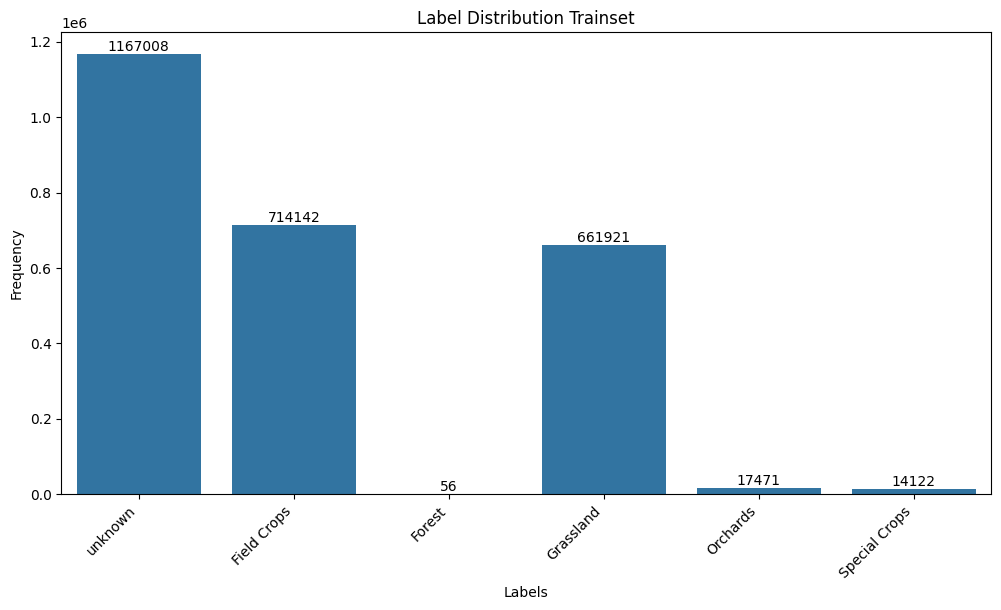

In [367]:
x_values, y_values = reshaped_target_train.flatten().unique(return_counts=True)

x_np = x_values.numpy()
y_np = y_values.numpy()
value_labels_level_1 = ['unknown','Field Crops','Forest','Grassland','Orchards','Special Crops']
ax = sns.barplot(x=x_np, y=y_np)

# Add value labels to the bars
for i, v in enumerate(y_np):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=10)

# Set plot labels and title
plt.title('Label Distribution Trainset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
ax.set_xticklabels(value_labels_level_1)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [368]:
# class distribution in percent trainset
np.round(y_np / len(reshaped_target_train.flatten())*100,2)

array([45.33, 27.74,  0.  , 25.71,  0.68,  0.55])

C:\Users\Tom\AppData\Local\Temp\ipykernel_13660\1108327787.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(value_labels_level_1)


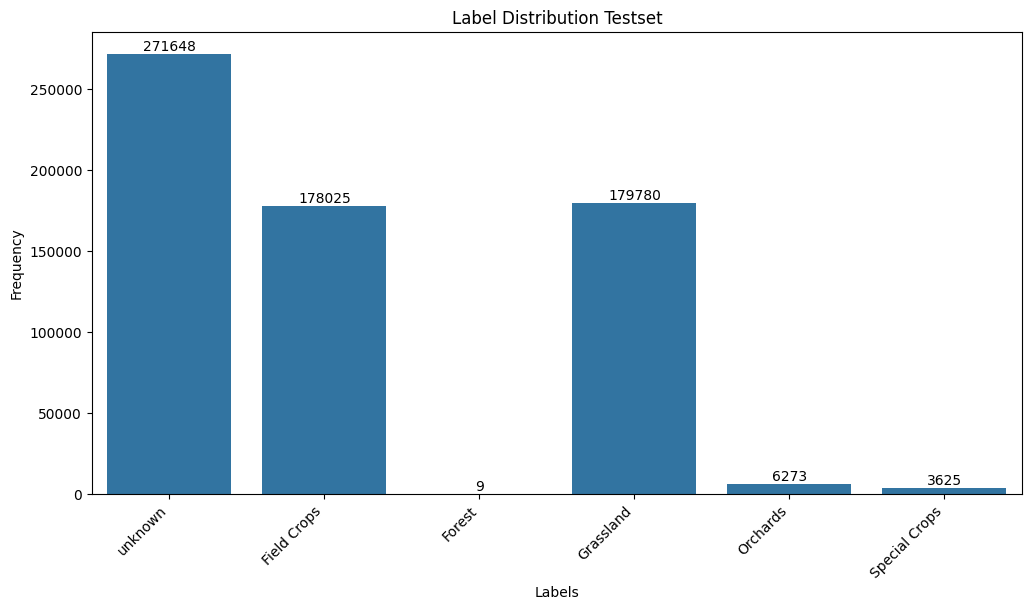

In [369]:
x_values, y_values = reshaped_target_test.flatten().unique(return_counts=True)

value_labels_level_1 = ['unknown','Field Crops','Forest','Grassland','Orchards','Special Crops']
x_np = x_values.numpy()
y_np = y_values.numpy()

# Create a bar plot using Seaborn
ax = sns.barplot(x=x_np, y=y_np)

# Add value labels to the bars
for i, v in enumerate(y_np):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=10)

# Set plot labels and title
plt.title('Label Distribution Testset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
ax.set_xticklabels(value_labels_level_1)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [ ]:
# class distribution in percent testset
np.round(y_np / len(reshaped_target_test.flatten())*100,2)

### Verteilung Felder
TODO:
Labels pro Feld ist wegen Aliasing effekte nicht immer gleich ein einzelnes, auch wenn man 0 als target entfernt haben einige felder noch eine 0 im target


In [ ]:
trainer.create_loader(eval_mode=True)

In [ ]:
input_train,target_train,field_instance_train = load_data_train(trainer,eval_mode=True)
target_train_array = target_train.flatten().numpy()
field_instance_train_array = field_instance_train.flatten().numpy()

# Create a DataFrame
df = pd.DataFrame({
    'Target': target_train_array,
    'Field_Instance': field_instance_train_array
})
# Group by 'Target' and count the occurrences of each 'Field_Instance'
value_counts_per_target = df.groupby('Target')['Field_Instance'].value_counts()
# Convert the Series to a DataFrame
result_df = value_counts_per_target.reset_index(name='Count')
# Pivot the DataFrame to have 'Field_Instance' values as columns
pivot_df = result_df.pivot(index='Target', columns='Field_Instance', values='Count').fillna(0)

In [343]:
pivot_df

Field_Instance,0,48204,98321,98322,98334,98342,98344,98355,98356,98369,...,253614,253640,253642,253654,253658,253659,253663,253673,253680,253686
Target,,,,,,,,,,,,,,,,,,,,,
0,1147718.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,2274.0,0.0,83.0,53.0,234.0,210.0,43.0,270.0,152.0,0.0,...,0.0,265.0,0.0,0.0,0.0,0.0,0.0,215.0,257.0,92.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3849.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,102.0,235.0,115.0,17.0,238.0,0.0,0.0,0.0
4,123.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [462]:
# Get row indexes per column where the value is not 0
indexes_not_zero = {}
for col in pivot_df.columns[1:]:
    non_zero_rows = pivot_df.index[pivot_df[col] != 0].tolist()
    indexes_not_zero[col] = non_zero_rows

keys_longer_than_one = {key: value for key, value in indexes_not_zero.items() if len(value) > 1}
print(f"There are {len([col for col, _ in keys_longer_than_one.items()])} Fields which have 2 or more labels assigned.")

There are 5789 Fields which have 2 or more labels assigned.


## Channel Distribution

TODO:
RGB and NIR Channel Distribution on the trainset with all timestamps

In [378]:
trainer = DeepModel_Trainer(r'D:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5', 'labels.csv', None, 'cpu',temporal_sampling=True)
trainer.create_loader(eval_mode=True)
input_train,target_train,field_instance_train = load_data_train(trainer,eval_mode=True)

5fold:  3   Mode:  test
Dataset size:  27977
Valid dataset size:  4477
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20
5fold:  4   Mode:  test
Dataset size:  27977
Valid dataset size:  1119
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20


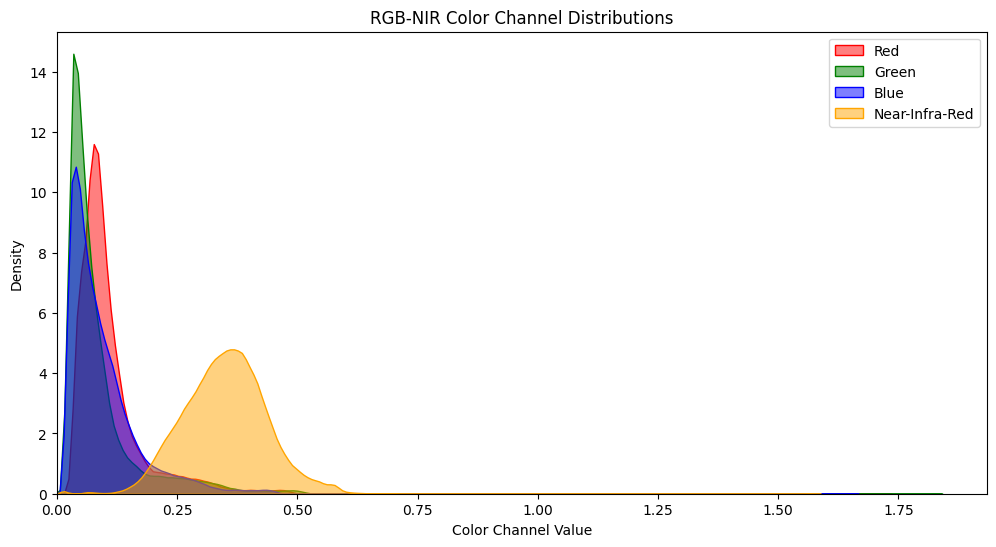

In [379]:
# RGB-NIR
sns.kdeplot(input_train[:,:,1,:,:].flatten().numpy(),color="red",fill=True,label="Red",alpha=0.5)
sns.kdeplot(input_train[:,:,2,:,:].flatten().numpy(),color="green",fill=True,label="Green",alpha=0.5)
sns.kdeplot(input_train[:,:,3,:,:].flatten().numpy(),color="blue",fill=True,label="Blue",alpha=0.5)
sns.kdeplot(input_train[:,:,0,:,:].flatten().numpy(),color="orange",fill=True,label="Near-Infra-Red",alpha=0.5)
plt.legend()
plt.title('RGB-NIR Color Channel Distributions')
plt.xlabel('Color Channel Value')
plt.xlim(0)
plt.show()

## Tile Charakteristiken    
#TODO: 
Charakteristiken der verschiedenen Tiles

In [428]:
targets_per_tile = []
pixel_class_per_tile = []
for i in range(target_train.size(0)):
    # get unique targets
    unique_targets_tile,targets_counts_tile = target_train[i].unique(return_counts=True)
    targets_per_tile.append(len(unique_targets_tile))

    missing_values = []
    for i in range(len(unique_targets_tile) - 1):
        diff = unique_targets_tile[i + 1] - unique_targets_tile[i]
        if diff > 1:
            # Insert the missing values up to the next value in unique_targets_tile
            missing_values.extend(range(unique_targets_tile[i] + 1, min(unique_targets_tile[i + 1], 6)))

        # Insert the missing values up to 5 if needed
    last_value = unique_targets_tile[-1].item() if len(unique_targets_tile) > 0 else 0
    missing_values.extend(range(last_value + 1, 6))
    # Check if zero is missing
    if unique_targets_tile[0].item() != 0:
        missing_values.append(0)
    new_tensor1 = torch.cat((unique_targets_tile[:1], torch.tensor(missing_values), unique_targets_tile[1:]))
    new_tensor2 = torch.cat((targets_counts_tile[:1], torch.zeros(len(missing_values)), targets_counts_tile[1:]))
    sorted_indices = torch.argsort(new_tensor1, descending=False)
    new_tensor1 = new_tensor1[sorted_indices]
    new_tensor2 = new_tensor2[sorted_indices]

    pixel_class_per_tile.append((new_tensor2 /(24*24)*100))

print(f"Average Targets per 24x24 Pixel Tile:\n{np.round(np.array(targets_per_tile).mean(),3)}")

Average Targets per 24x24 Pixel Tile:
3.02


In [429]:
stacked_tensor = torch.stack(pixel_class_per_tile)
column_means = torch.mean(stacked_tensor, dim=0)

values ={value_labels_level_1[i]:v for i,v in enumerate( np.round(column_means.numpy(),3))}

print(f"Average Class Area % per 24x24 Pixel Tile:\n{values}")

Average Class Area % per 24x24 Pixel Tile:
{'unknown': 45.305, 'Field Crops': 27.78, 'Forest': 0.002, 'Grassland': 25.688, 'Orchards': 0.677, 'Special Crops': 0.548}


In [430]:
fields_per_tile = []
pixel_class_per_tile = []
for i in range(target_train.size(0)):
    # get unique targets
    unique_fields_tile,fields_counts_tile = field_instance_train[i].unique(return_counts=True)
    fields_per_tile.append(len(unique_fields_tile))
print(f"Average Fields per 24x24 Pixel Tile:\n{np.round(np.array(fields_per_tile).mean(),3)}")

Average Fields per 24x24 Pixel Tile:
9.577


## Beispiels Tiles

TODO:
Plots der Satelitendaten mit einmal RGB und einmal NIR-GB sowie der Ground-Truth. Strukuren der Labels kann in den satellitendaten nachvollzogen werden

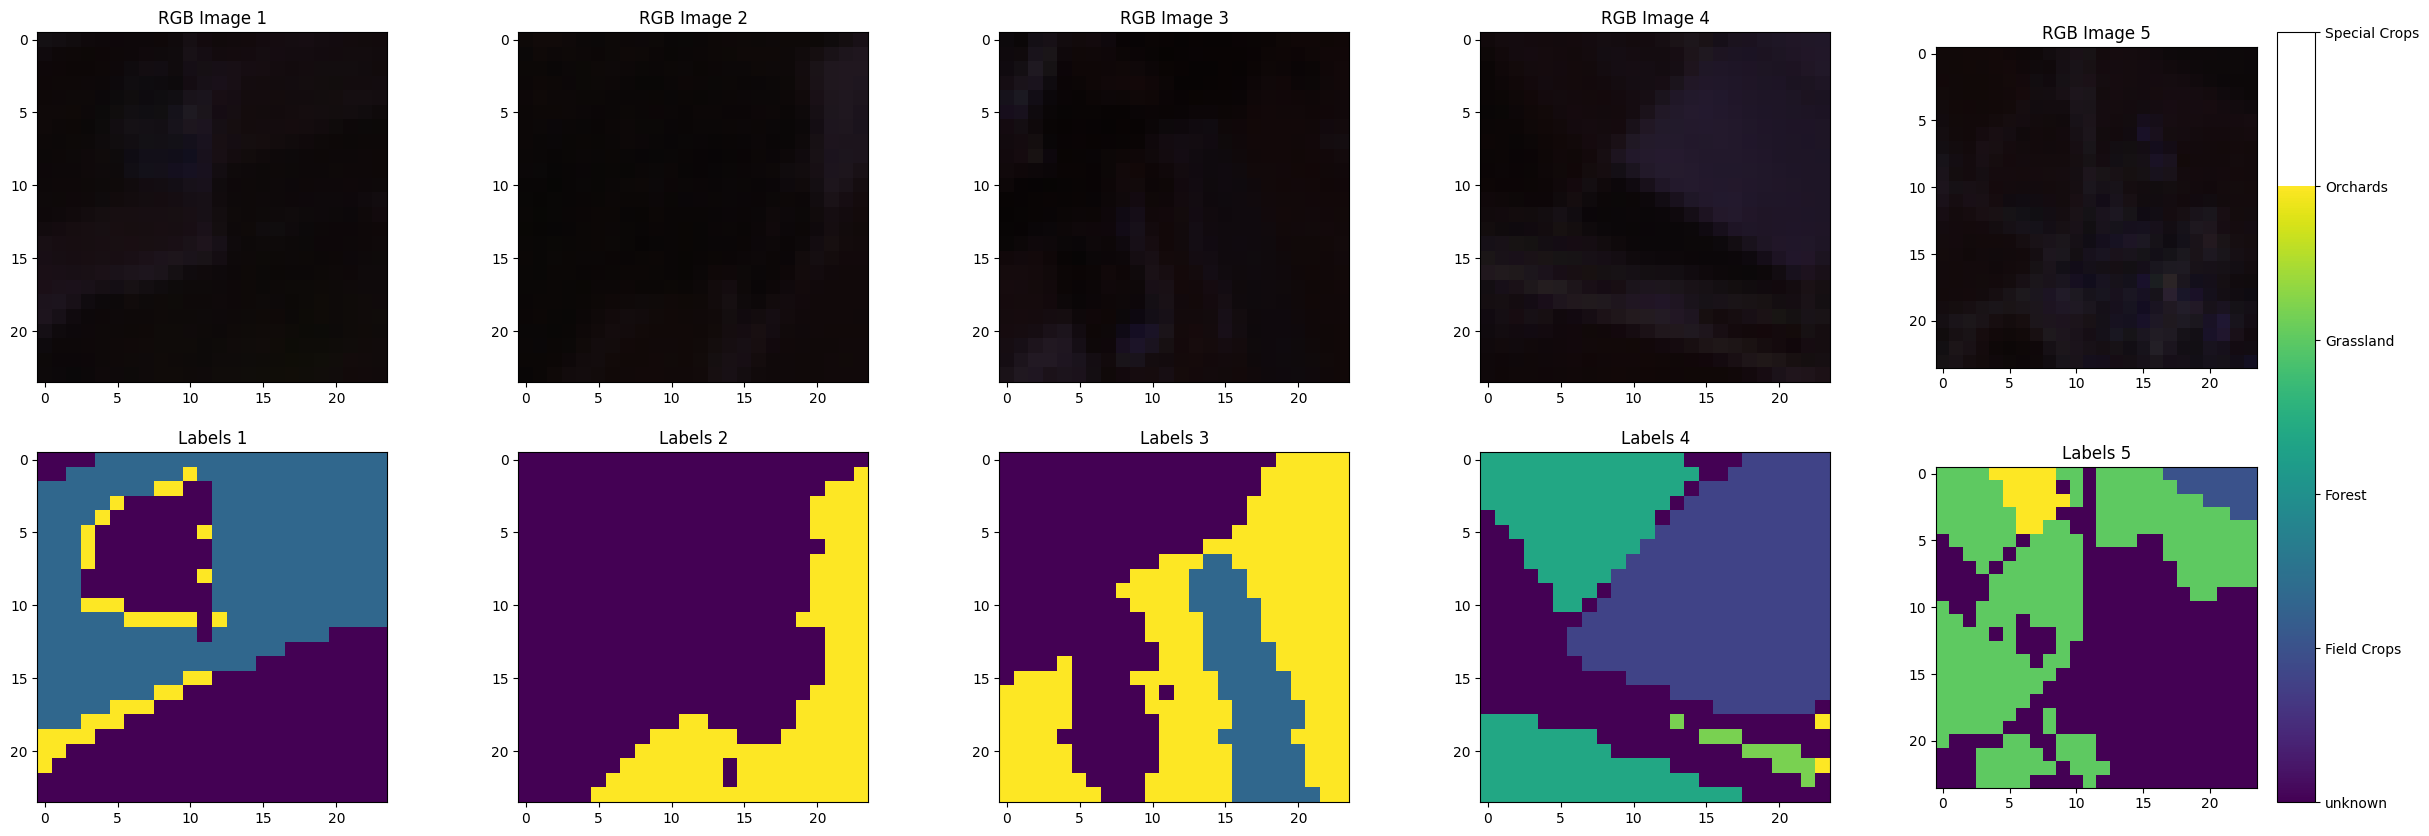

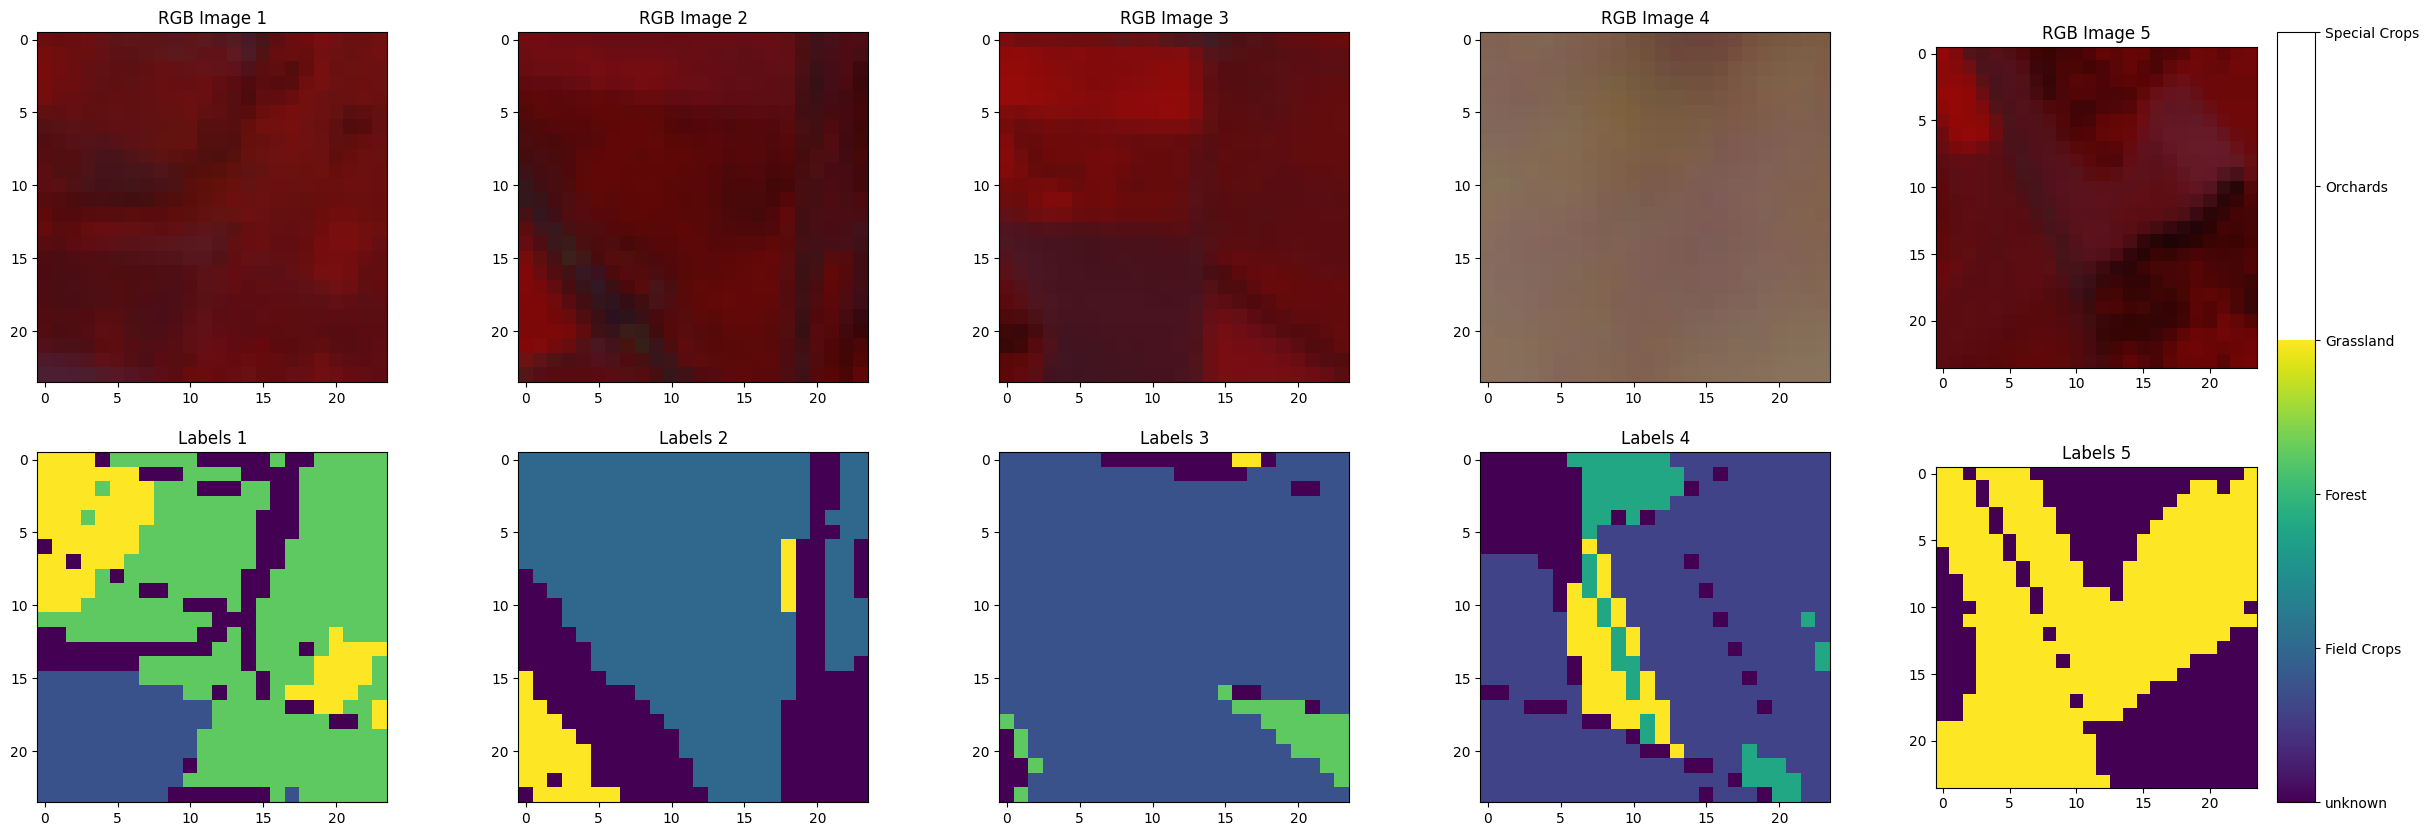

In [463]:
# Plotting
fig, axs = plt.subplots(2, 5, figsize=(30, 10))  # Updated to 6 rows
# Your labels
label_mapping = {i:v for i,v in enumerate(value_labels_level_1)}
# Plot 5 more random samples
for i in range(0, 5):
    random_index = random_index = np.random.randint(0, len(input_train))
    rgb_image = input_train[random_index]
    labels = target_train[random_index]
    rgb_channels = rgb_image[:, [1, 2, 3], :, :]
    # Make sure the tensor is in the range [0, 1]
    rgb_channels = torch.clamp(rgb_channels, 0, 1)
    # Plot RGB image
    rgb_image_to_plot = rgb_channels.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    # print(rgb_image_to_plot)
    axs[0, i].imshow(rgb_image_to_plot,cmap='gray')
    axs[0, i].set_title(f'RGB Image {i+1}')

    # Plotting
    img = axs[1, i].imshow(labels.cpu().detach().numpy(), cmap='viridis')
    axs[1, i].set_title(f'Labels {i+1}')


# Add colorbar for the entire figure
cbar = fig.colorbar(img, ax=axs[:, -1])  # Adjust the shrink parameter as needed
cbar.set_ticks(list(label_mapping.keys()))
cbar.set_ticklabels(list(label_mapping.values()))
# Show the plots
plt.show()
# Plotting
fig, axs = plt.subplots(2, 5, figsize=(30, 10))  # Updated to 6 rows
# Your labels
label_mapping = {i:v for i,v in enumerate(value_labels_level_1)}
# Plot 5 more random samples
for i in range(0, 5):
    random_index = random_index = np.random.randint(0, len(input_train))
    rgb_image = input_train[random_index]
    labels = target_train[random_index]
    rgb_channels = rgb_image[:, [0, 2, 3], :, :]
    # Make sure the tensor is in the range [0, 1]
    rgb_channels = torch.clamp(rgb_channels, 0, 1)
    # Plot RGB image
    rgb_image_to_plot = rgb_channels.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    axs[0, i].imshow(rgb_image_to_plot,cmap='gray')
    axs[0, i].set_title(f'RGB Image {i+1}')

    # Plotting
    img = axs[1, i].imshow(labels.cpu().detach().numpy(), cmap='viridis')
    axs[1, i].set_title(f'Labels {i+1}')


# Add colorbar for the entire figure
cbar = fig.colorbar(img, ax=axs[:, -1])  # Adjust the shrink parameter as needed
cbar.set_ticks(list(label_mapping.keys()))
cbar.set_ticklabels(list(label_mapping.values()))

plt.show()

## Feld Charakteristiken

#TODO: characteristiken der feldinstanzen

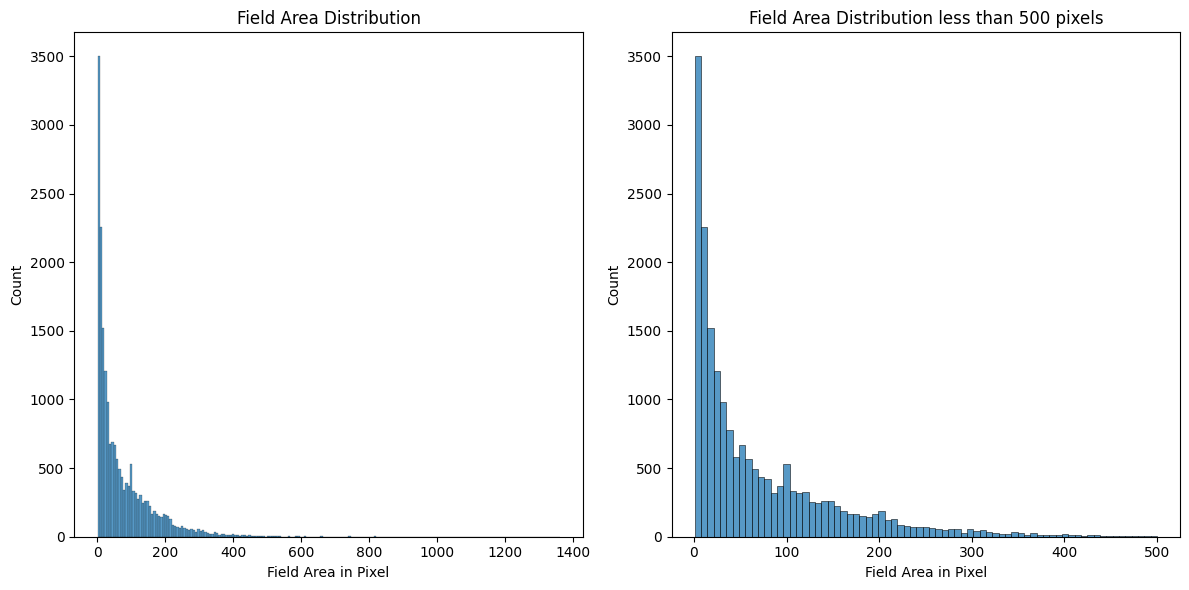

In [416]:
unique_fields_tile,fields_counts_tile = field_instance_train.flatten().unique(return_counts=True)
#remove the 0
unique_fields_tile= unique_fields_tile[1:]
fields_counts_tile= fields_counts_tile[1:]
sorted_indices = torch.argsort(fields_counts_tile, descending=True)
unique_fields_tile = unique_fields_tile[sorted_indices]
fields_counts_tile = fields_counts_tile[sorted_indices]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(fields_counts_tile[fields_counts_tile <= 500], ax=axes[1])
axes[1].set_title('Field Area Distribution less than 500 pixels')
axes[1].set_xlabel('Field Area in Pixel')
sns.histplot(fields_counts_tile, ax=axes[0])
axes[0].set_title('Field Area Distribution')
axes[0].set_xlabel('Field Area in Pixel')
plt.tight_layout()
plt.show()


## Beispielsfelder

TODO: 
nachfolgend einige beispiele von feldinstanzen und deren labels sowie den satelliten daten

In [411]:
fields = [unique_fields_tile[i ].numpy().max() for i in [600,2000]]
fields

[171366, 191974]

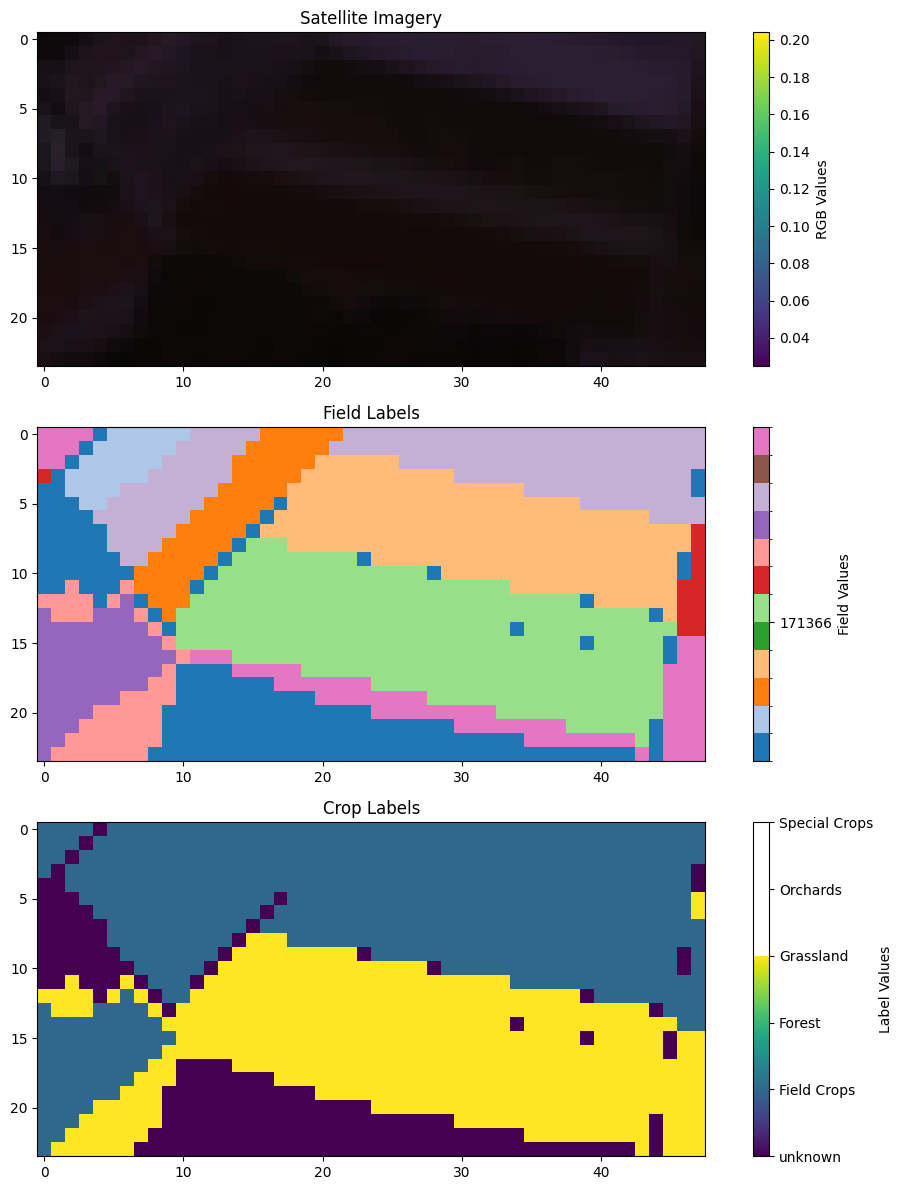

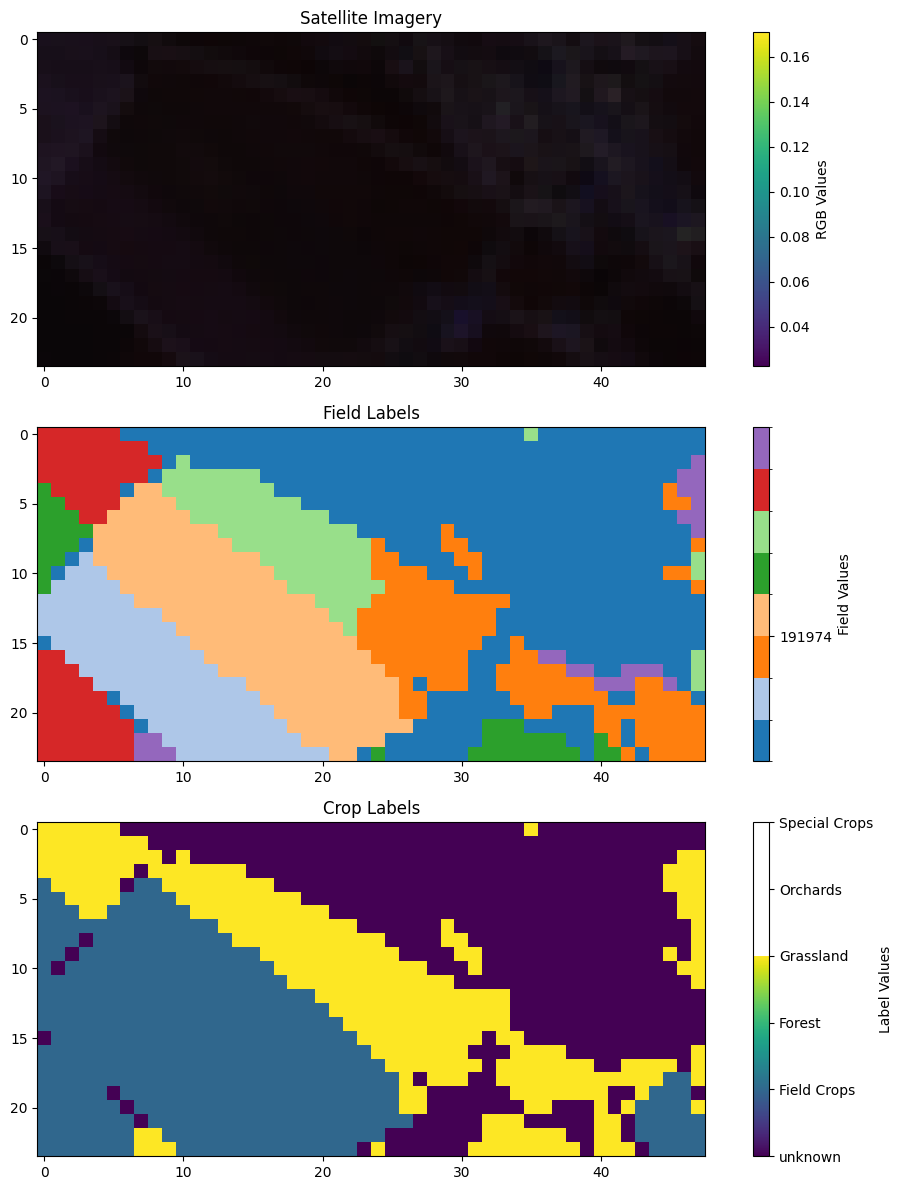

In [412]:
for field in fields:
    tensor_for_data = []
    tensor_for_field = []
    tensor_for_target = []
    for i in range(target_train.size(0)):
        has_value_field = torch.any(field_instance_train[i] == field).item()
        if has_value_field:
            tensor_for_data.append(input_train[i,:,1:4,:,:])
            tensor_for_field.append(field_instance_train[i])
            tensor_for_target.append(target_train[i])

    stacked_tensor_field = torch.cat(tensor_for_field, dim=1)
    stacked_tensor_target = torch.cat(tensor_for_target, dim=1)
    tensor_for_data =torch.stack(tensor_for_data)
    tensor_for_data = torch.clamp(tensor_for_data, 0, 1)
    stacked_image = torch.cat([tensor_for_data[i] for i in range(tensor_for_data.size(0))], dim=3)

    stacked_image = stacked_image.squeeze().permute(1, 2, 0).numpy()
    label_mapping_fields_field = {field:field}
    label_mapping_fields = {v:v for i,v in enumerate(tensor_for_field[0].unique().numpy())}

    # Plot the image
    plt.figure(figsize=(10, 12))  # Adjust the width and height as needed
    # Create a gridspec layout
    gs = gridspec.GridSpec(3, 1, width_ratios=[4], height_ratios=[1, 1, 1])

    # Plot the image
    ax0 = plt.subplot(gs[0])
    im0 =ax0.imshow(stacked_image,)
    ax0.set_title('Satellite Imagery')
    cbar1 = plt.colorbar(im0, ax=ax0)
    cbar1.set_label('RGB Values')

    # Extract unique category values
    unique_categories = sorted(list(set(label_mapping_fields.values())))
    # Define colors for each category
    category_colors = plt.cm.tab20.colors[:len(unique_categories)]
    # Create a colormap with specified colors
    cmap = colors.ListedColormap(category_colors)
    # Define bounds and norm
    bounds = unique_categories 
    norm = colors.BoundaryNorm(bounds, cmap.N)
    # Plot the pixel labels
    ax1 = plt.subplot(gs[1])
    im1 = ax1.imshow(stacked_tensor_field,cmap=cmap,norm=norm,origin='upper')
    ax1.set_title('Field Labels')
    # make a color bar
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Field Values')
    cbar1.set_ticks(list(label_mapping_fields_field.keys()))
    cbar1.set_ticklabels(list(label_mapping_fields_field.values()))

    # Plot the pixel labels
    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(stacked_tensor_target)
    ax2.set_title('Crop Labels')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Label Values')
    cbar2.set_ticks(list(label_mapping.keys()))
    cbar2.set_ticklabels(list(label_mapping.values()))

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


## Weitere Analysen

#TODO:
weitere Analysen wie Rundheit und Bounding Boxes ineinander wurden nicht durchgeführt, da die Ground-Truth es nicht immer erlaubt, die Felder in ihren korrekten räumlichen Dimensionen zurückzuverfolgen

## Conclusion EDA DLBS

TODO: